In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import copy


/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


2019-07-23 15:37:53 MainProcess:INFO:root:Created Konrad object:
RCE(
    atmosphere=Atmosphere,
    radiation=RRTMG,
    ozone=OzonePressure,
    humidity=FixedRH,
    surface=SurfaceHeatCapacity,
    cloud=<konrad.cloud.ClearSky object at 0x7efc31001978>,
    convection=HardAdjustment,
    lapserate=MoistLapseRate,
    upwelling=NoUpwelling,
    aerosol=<konrad.aerosol.NoAerosol object at 0x7efc31001860>,
    max_duration=12000.0,
    timestep=0.6666666666666666,
    writeevery=200,
    max_iterations=18000.0,
    niter=0,
    delta=0.0001,
    deltaT=None,
    converged=False,
    outfile=/scratch/local1/m300733/convergence5.nc,
    nchandler=None,
    experiment=RCE,
)
2019-07-23 15:37:53 MainProcess:INFO:konrad.core:Start RCE model run.
2019-07-23 15:37:53 MainProcess:INFO:konrad.core:Enter iteration 0.
2019-07-23 15:37:56 MainProcess:INFO:konrad.core:Enter iteration 100.
2019-07-23 15:37:58 MainProcess:INFO:konrad.core:Enter iteration 200.
2019-07-23 15:38:00 MainProcess:INFO:kon

2019-07-23 15:41:23 MainProcess:INFO:konrad.core:Enter iteration 900.
2019-07-23 15:41:25 MainProcess:INFO:konrad.core:Enter iteration 1000.
2019-07-23 15:41:28 MainProcess:INFO:konrad.core:Enter iteration 1100.
2019-07-23 15:41:30 MainProcess:INFO:konrad.core:Enter iteration 1200.
2019-07-23 15:41:32 MainProcess:INFO:konrad.core:Enter iteration 1300.
2019-07-23 15:41:34 MainProcess:INFO:konrad.core:Enter iteration 1400.
2019-07-23 15:41:36 MainProcess:INFO:konrad.core:Enter iteration 1500.
2019-07-23 15:41:38 MainProcess:INFO:konrad.core:Enter iteration 1600.
2019-07-23 15:41:41 MainProcess:INFO:konrad.core:Enter iteration 1700.
2019-07-23 15:41:43 MainProcess:INFO:konrad.core:Enter iteration 1800.
2019-07-23 15:41:45 MainProcess:INFO:konrad.core:Enter iteration 1900.
2019-07-23 15:41:47 MainProcess:INFO:konrad.core:Enter iteration 2000.
2019-07-23 15:41:49 MainProcess:INFO:konrad.core:Enter iteration 2100.
2019-07-23 15:41:52 MainProcess:INFO:konrad.core:Enter iteration 2200.
2019-07

2019-07-23 15:45:13 MainProcess:INFO:konrad.core:Enter iteration 1900.
2019-07-23 15:45:16 MainProcess:INFO:konrad.core:Enter iteration 2000.
2019-07-23 15:45:18 MainProcess:INFO:konrad.core:Enter iteration 2100.
2019-07-23 15:45:20 MainProcess:INFO:konrad.core:Enter iteration 2200.
2019-07-23 15:45:22 MainProcess:INFO:konrad.core:Enter iteration 2300.
2019-07-23 15:45:25 MainProcess:INFO:konrad.core:Enter iteration 2400.
2019-07-23 15:45:27 MainProcess:INFO:konrad.core:Enter iteration 2500.
2019-07-23 15:45:29 MainProcess:INFO:konrad.core:Enter iteration 2600.
2019-07-23 15:45:31 MainProcess:INFO:konrad.core:Enter iteration 2700.
2019-07-23 15:45:34 MainProcess:INFO:konrad.core:Enter iteration 2800.
2019-07-23 15:45:36 MainProcess:INFO:konrad.core:Enter iteration 2900.
2019-07-23 15:45:38 MainProcess:INFO:konrad.core:Enter iteration 3000.
2019-07-23 15:45:41 MainProcess:INFO:konrad.core:Enter iteration 3100.
2019-07-23 15:45:43 MainProcess:INFO:konrad.core:Enter iteration 3200.
2019-0

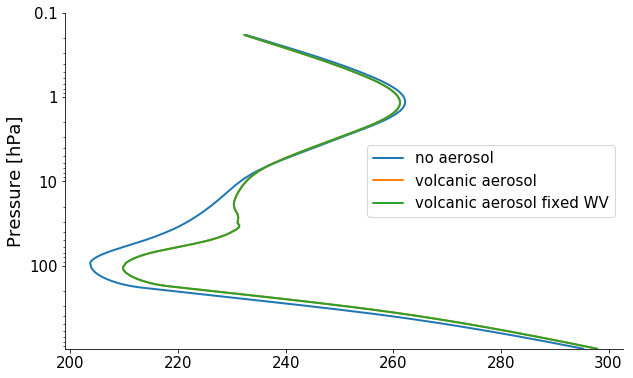

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from typhon import plots

import konrad
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
atmosphere = konrad.atmosphere.Atmosphere(plev)
solarConstant=500
Albedo=0.2
fixedRH=0.2
pressureLimitIndex=165
maxDuration='12000d'
maxDuration2='8000d'
pressureMin=10
run=str(5)
upwellingVelocity=0
convergenceFile='convergence'+run+'.nc'
convergenceFileAerosol='convergenceAerosol'+run+'.nc'
convergenceInputPath='/scratch/local1/m300733/'+convergenceFile
convergenceInputPathAerosol='/scratch/local1/m300733/'+convergenceFileAerosol
stratospheric_upwelling = konrad.upwelling.StratosphericUpwelling(w=upwellingVelocity)

# Load a standard atmosphere.
#atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
#    ncfile='data/tropical-standard.nc',
#)
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.

# Plot the initial temperature profile (for comparison).
plt.style.use(plots.styles('typhon'))
fig, ax = plt.subplots()
#plots.profile_p_log(atmosphere['plev'], atmosphere['T'][-1, :], label='Initial state')
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    #surface=surface,
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =42.05),  # Use RRTMG radiation scheme.
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)), 
    upwelling=stratospheric_upwelling,
    max_duration=maxDuration,  # Set maximum runtime.
    aerosol=konrad.aerosol.NoAerosol(),
    outfile=convergenceInputPath ,
    writeevery=200,
)
rce.run()  # Start the simulation.
# Plot the equilibrium temperature profile.
noAerosolAtm=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='no aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =42.05),  # Use RRTMG radiation scheme.
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    upwelling=stratospheric_upwelling,
    outfile=convergenceInputPathAerosol,
    writeevery=200,
)
rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
AerosolAtm=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

rce = konrad.RCE(
    noAerosolAtm,
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =42.05),  # Use RRTMG radiation scheme.
    convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    humidity=konrad.humidity.FixedVMR(),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    outfile=convergenceInputPathAerosol,
    upwelling=stratospheric_upwelling,
    writeevery=200,
)
rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
AerosolAtmFixWV=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol fixed WV')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)

42

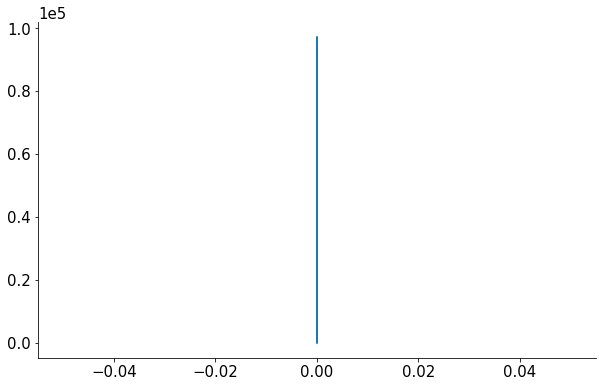

In [11]:
plt.close()
import matplotlib.pyplot as plt
#noAerosolAtm['relative_humidity']
noAerosolAtm.get_cold_point_plev()
fig,ax=plt.subplots(1,1)
ax.plot(AerosolAtm['H2O'][0,:]-AerosolAtm['H2O'][0,:],dataAerosol['plev'])
dataNoAerosol['radiation']['sw_htngrt'].shape
dataNoAerosol['radiation']['lw_htngrt'].shape
dataAerosol['radiation']['lw_htngrt'].shape
dataNoAerosol['radiation']['sw_htngrt'].shape[0]-1

ValueError: x and y must have same first dimension, but have shapes (199,) and (200,)

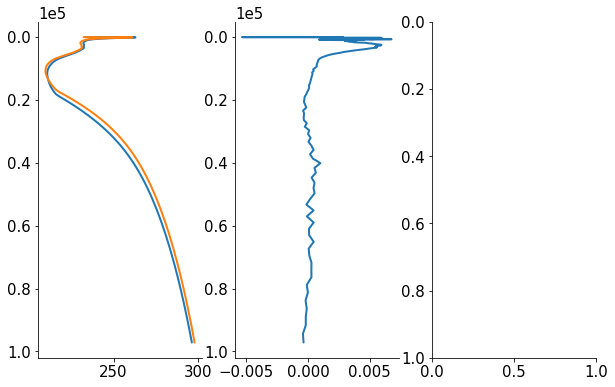

In [12]:
fig,ax=plt.subplots(1,3)
ax[0].plot(noAerosolAtm['T'][-1, 0:pressureLimitIndex], noAerosolAtm['plev'][0:pressureLimitIndex], label='no volcanic aerosol')
ax[0].plot(AerosolAtm['T'][-1, 0:pressureLimitIndex], AerosolAtm['plev'][0:pressureLimitIndex], label='volcanic aerosol')
plt.gca().invert_yaxis()
ax[1].invert_yaxis()
ax[0].invert_yaxis()
ax[1].plot(-dataNoAerosol['radiation']['sw_htngrt'][dataNoAerosol['radiation']['sw_htngrt'].shape[0]-1,:]+dataAerosol['radiation']['sw_htngrt'][dataAerosol['radiation']['sw_htngrt'].shape[0]-1,:],dataNoAerosol['plev'][:], label='sw: difference aerosol - no_aerosol')
ax[1].plot(-dataNoAerosol['radiation']['lw_htngrt'][dataNoAerosol['radiation']['sw_htngrt'].shape[0]-1,:-1]+dataAerosol['radiation']['lw_htngrt'][dataAerosol['radiation']['sw_htngrt'].shape[0]-1,:-1],dataAerosol['plev'][:], label='lw: difference aerosol - no_aerosol')
ax[2].plot(-noAerosolAtm['H2O'][0,:]+AerosolAtm['H2O'][0,:],dataAerosol['plev'], label='vmr: difference aerosol - no_aerosol')
#ax = plt.gca()
#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
#plt.gca().invert_yaxis()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[2].invert_yaxis()
 
plt.gca().invert_yaxis()
#ax.plt(axis='equal')
ax[0].set_xlabel('temperature')
ax[0].set_ylabel('pressure [Pa]')
plt.gca().set_aspect('equal', adjustable='box')
ax[1].set_xlabel('heating rates [K/day]')
ax[1].set_ylabel('pressure [Pa]')
ax[2].set_xlabel('H2O vmr')
ax[2].set_ylabel('pressure [Pa]')
plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0].legend()
ax[1].legend()
ax[2].legend()

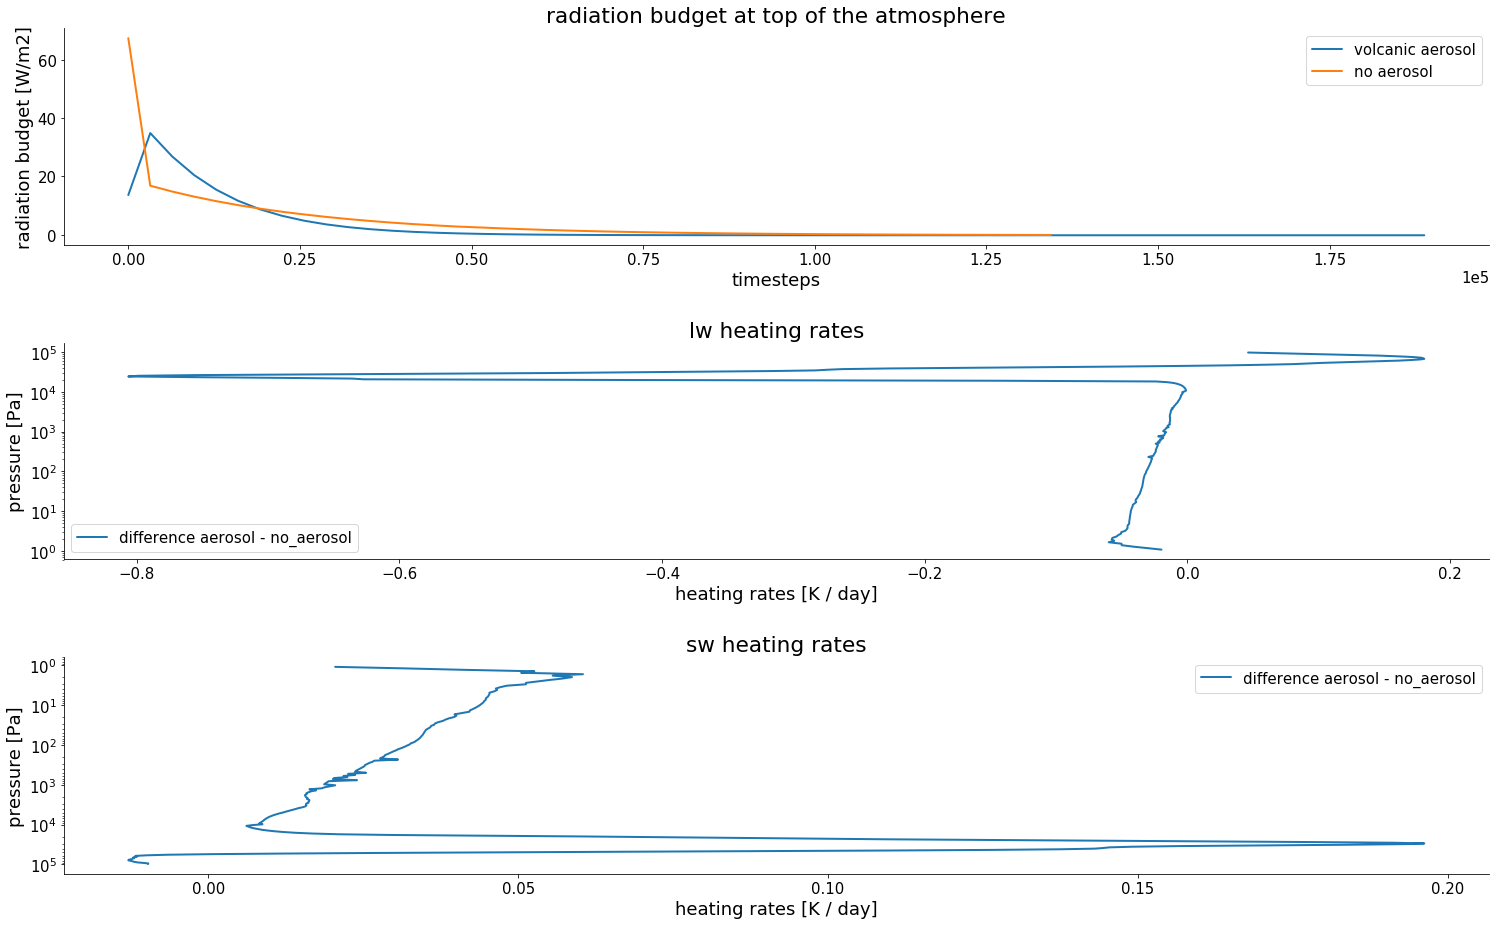

In [4]:
from netCDF4 import Dataset
dataNoAerosol=Dataset('/scratch/local1/m300733/convergence5.nc')
dataAerosol=Dataset('/scratch/local1/m300733/convergenceAerosol5.nc')
fig,ax=plt.subplots(3,1)
#plt.suptitle('run without aerosol',fontsize=16)
ax[0].plot(dataAerosol['time'],dataAerosol['radiation']['toa'],label='volcanic aerosol')
ax[0].plot(dataNoAerosol['time'],dataNoAerosol['radiation']['toa'],label='no aerosol')

ax[1].plot(-dataNoAerosol['radiation']['lw_htngrt'][5,:]+dataAerosol['radiation']['lw_htngrt'][5,:],dataAerosol['plev'],label='difference aerosol - no_aerosol')
#ax[1].plot(dataNoAerosol['radiation']['lw_htngrt'][5,:],dataNoAerosol['plev'],label='no aerosol')
#ax[2].plot(dataAerosol['radiation']['sw_htngrt'][5,:],dataAerosol['plev'],label='volcanic aerosol')
ax[2].plot(-dataNoAerosol['radiation']['sw_htngrt'][5,:]+dataAerosol['radiation']['sw_htngrt'][5,:],dataNoAerosol['plev'],label='difference aerosol - no_aerosol')

ax[0].set_title('radiation budget at top of the atmosphere')
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel('radiation budget [W/m2]')
 
plt.gca().invert_yaxis()
ax[1].set_yscale('log')
#ax[1].invert_yaxis()
ax[1].set_title('lw heating rates')
ax[1].set_ylabel('pressure [Pa]')
ax[1].set_xlabel('heating rates [K / day]')

#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
ax[2].set_yscale('log')
#ax[2].invert_yaxis()
ax[2].set_title('sw heating rates')
ax[2].set_xlabel('heating rates [K / day]')
ax[2].set_ylabel('pressure [Pa]')

plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [124]:
test=copy.copy(atmosphere)

KeyError: '__getstate__'

In [120]:
atmosphere['phlev']


array([9.85712252e+04, 9.57609806e+04, 9.30043485e+04, 9.03013340e+04,
       8.76518966e+04, 8.50559521e+04, 8.25133735e+04, 8.00239929e+04,
       7.75876025e+04, 7.52039561e+04, 7.28727708e+04, 7.05937284e+04,
       6.83664764e+04, 6.61906300e+04, 6.40657734e+04, 6.19914612e+04,
       5.99672196e+04, 5.79925484e+04, 5.60669221e+04, 5.41897912e+04,
       5.23605838e+04, 5.05787071e+04, 4.88435485e+04, 4.71544770e+04,
       4.55108449e+04, 4.39119885e+04, 4.23572300e+04, 4.08458783e+04,
       3.93772304e+04, 3.79505729e+04, 3.65651825e+04, 3.52203280e+04,
       3.39152707e+04, 3.26492658e+04, 3.14215635e+04, 3.02314101e+04,
       2.90780486e+04, 2.79607201e+04, 2.68786646e+04, 2.58311216e+04,
       2.48173314e+04, 2.38365357e+04, 2.28879784e+04, 2.19709064e+04,
       2.10845702e+04, 2.02282249e+04, 1.94011304e+04, 1.86025523e+04,
       1.78317628e+04, 1.70880403e+04, 1.63706711e+04, 1.56789490e+04,
       1.50121762e+04, 1.43696635e+04, 1.37507309e+04, 1.31547080e+04,
      